# **Modeling**

## Import thư viện từ src

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Thiết lập để import được từ thư mục src/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.models import (
    load_xy_from_clean_csv,
    train_val_split,
    LogisticRegressionBinary,
    evaluate_binary_classification,
    cross_val_logistic,
)

RANDOM_STATE = 23120329
CLEAN_CSV_PATH = "../data/processed/aug_train.csv"
TARGET_COL     = "target"   

## Load dữ liệu đã xử lí

In [2]:
# Load X, y từ file CSV sạch
X, y, feature_names = load_xy_from_clean_csv(
    csv_path=CLEAN_CSV_PATH,
    target_col=TARGET_COL,
)

print("Kích thước X:", X.shape)      # (n_samples, n_features)
print("Kích thước y:", y.shape)      # (n_samples, )
print("Số lượng feature:", len(feature_names))
print("Một vài feature đầu:", feature_names[:10])

Kích thước X: (19158, 158)
Kích thước y: (19158,)
Số lượng feature: 158
Một vài feature đầu: ['city_development_index_z', 'training_hours_log_z', 'experience_ord', 'company_size_ord', 'last_new_job_ord', 'gender=Female', 'gender=Male', 'gender=Other', 'gender=Unknown', 'enrolled_university=Full time course']


## Chia train/validation và baseline

In [3]:
# Chia train / validation
X_train, X_val, y_train, y_val = train_val_split(
    X,
    y,
    val_ratio=0.2,
    shuffle=True,
    random_state=RANDOM_STATE,
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)

# Baseline: luôn đoán lớp majority (dựa trên train)
train_pos_ratio = np.mean(y_train)
majority_class = int(train_pos_ratio >= 0.5)

print("\nTỷ lệ target=1 trên train:", train_pos_ratio)
print("Majority class (baseline):", majority_class)

y_val_baseline = np.full_like(y_val, fill_value=majority_class)
baseline_acc = np.mean(y_val_baseline == y_val)
print("Baseline accuracy (always majority):", baseline_acc)

Train: (15326, 158) (15326,)
Val  : (3832, 158) (3832,)

Tỷ lệ target=1 trên train: 0.24814041498107792
Majority class (baseline): 0
Baseline accuracy (always majority): 0.7458246346555324


## Traininng cho model

[Epoch    0] Loss = 0.720131
[Epoch  100] Loss = 0.482844
[Epoch  200] Loss = 0.472659
[Epoch  300] Loss = 0.467756
[Epoch  400] Loss = 0.464652
[Epoch  500] Loss = 0.462597
[Epoch  600] Loss = 0.461176
[Epoch  700] Loss = 0.460123
[Epoch  800] Loss = 0.459308
[Epoch  900] Loss = 0.458659
[Epoch 1000] Loss = 0.458131
[Epoch 1100] Loss = 0.457692
[Epoch 1200] Loss = 0.457321
[Epoch 1300] Loss = 0.457002
[Epoch 1400] Loss = 0.456726
[Epoch 1499] Loss = 0.456485


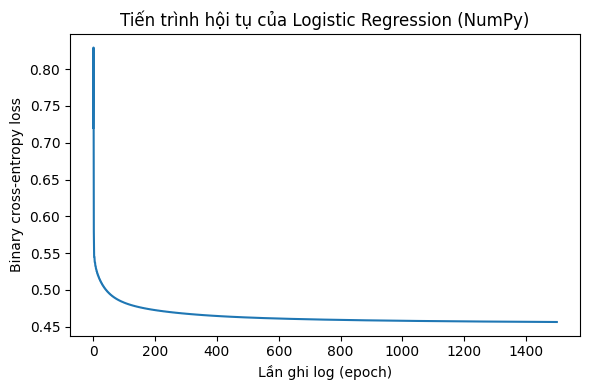

In [4]:
# Khởi tạo mô hình Logistic Regression 
clf = LogisticRegressionBinary(
    lr=0.1,
    n_epochs=1500,
    l2=0.001,
    fit_intercept=True,
    verbose=True,          
    random_state=RANDOM_STATE,
)

# Huấn luyện mô hình trên tập train
clf.fit(X_train, y_train)

# Vẽ đường hội tụ của loss 
if len(clf.loss_history_) > 0:
    plt.figure(figsize=(6, 4))
    plt.plot(clf.loss_history_)
    plt.xlabel("Lần ghi log (epoch)")
    plt.ylabel("Binary cross-entropy loss")
    plt.title("Tiến trình hội tụ của Logistic Regression (NumPy)")
    plt.tight_layout()
    plt.show()

## Đánh giá mô hình trên tập Validation

In [5]:
# Dự đoán xác suất trên tập validation
y_val_prob = clf.predict_proba(X_val)

# Đánh giá với threshold = 0.5
metrics_val = evaluate_binary_classification(
    y_true=y_val,
    y_prob=y_val_prob,
    threshold=0.5,
    positive_label=1,
)

print("=== Validation metrics (threshold = 0.5) ===")
for k, v in metrics_val.items():
    if k != "confusion_matrix":
        # in đẹp với float
        print(f"{k:>16s} : {v:.4f}" if isinstance(v, float) else f"{k:>16s} : {v}")
print("Confusion matrix (TN FP; FN TP):")
print(metrics_val["confusion_matrix"])

print("\nSo sánh với baseline:")
print("- Baseline accuracy:", baseline_acc)
print("- Model accuracy   :", metrics_val["accuracy"])

=== Validation metrics (threshold = 0.5) ===
        accuracy : 0.7753
       precision : 0.6123
          recall : 0.3162
              f1 : 0.4171
       threshold : 0.5000
Confusion matrix (TN FP; FN TP):
[[2663  195]
 [ 666  308]]

So sánh với baseline:
- Baseline accuracy: 0.7458246346555324
- Model accuracy   : 0.7753131524008351


## Thử nhiều threshold (trade-off Precision / Recall)

In [6]:
thresholds = [0.3, 0.4, 0.5, 0.6]

print("Threshold | Accuracy | Precision | Recall | F1")
print("------------------------------------------------")
for th in thresholds:
    m = evaluate_binary_classification(
        y_true=y_val,
        y_prob=y_val_prob,
        threshold=th,
        positive_label=1,
    )
    print(f"{th:8.2f} | {m['accuracy']:.4f}  | {m['precision']:.4f}   | {m['recall']:.4f} | {m['f1']:.4f}")

Threshold | Accuracy | Precision | Recall | F1
------------------------------------------------
    0.30 | 0.7855  | 0.5632   | 0.6951 | 0.6222
    0.40 | 0.7826  | 0.5848   | 0.4990 | 0.5385
    0.50 | 0.7753  | 0.6123   | 0.3162 | 0.4171
    0.60 | 0.7625  | 0.6176   | 0.1725 | 0.2697


## K-fold Cross-Validation (tuỳ chọn, nhưng đẹp bài)
Ý tưởng

Một lần chia train/validation có thể “may mắn” hoặc “xui”.

Cross-validation (ví dụ 5-fold) giúp:

Đánh giá mô hình trên nhiều cách chia khác nhau.

Lấy trung bình các metric trên 5 folds → kết quả ổn định hơn.

Dùng cross_val_logistic (đã cài trong src/models.py):

Nội bộ tạo các fold index,

Mỗi fold train một Logistic Regression mới,

Lưu lại metrics từng fold,

Trả về trung bình Accuracy/Precision/Recall/F1.

In [7]:
# Thực hiện 5-fold cross-validation trên toàn bộ dữ liệu X, y
cv_results = cross_val_logistic(
    X,
    y,
    k=5,
    lr=0.1,
    n_epochs=1500,
    l2=0.001,
    fit_intercept=True,
    verbose=False,
    random_state=RANDOM_STATE,
    threshold=0.5,
)

print("=== 5-fold CV results (mean over folds) ===")
print("Accuracy :", cv_results["accuracy"])
print("Precision:", cv_results["precision"])
print("Recall   :", cv_results["recall"])
print("F1-score :", cv_results["f1"])

=== 5-fold CV results (mean over folds) ===
Accuracy : 0.7771168235834575
Precision: 0.601909373959555
Recall   : 0.3163114217950562
F1-score : 0.4142433620221295


## Tổng kết phần Modeling

Trong phần này, ta đã:

1. **Load dữ liệu sạch** từ file CSV, tách ma trận đặc trưng \\(X\\) và nhãn \\(y\\).
2. **Chia dữ liệu** thành tập train (80%) và validation (20%), xây dựng baseline
   luôn đoán lớp majority.
3. Cài đặt và huấn luyện **Logistic Regression thuần NumPy**:
   - Hàm sigmoid + binary cross-entropy,
   - Tối ưu bằng gradient descent full-batch,
   - Thêm L2 regularization để giảm overfitting.
4. **Đánh giá mô hình** trên tập validation:
   - Model đạt Accuracy ≈ `...`, cao hơn baseline (≈ `...`),
   - Precision, Recall, F1 ở mức `...`,
   - Phân tích Confusion Matrix để hiểu rõ các lỗi FP/FN.
5. **Phân tích threshold**:
   - Threshold thấp → Recall cao hơn nhưng Precision giảm,
   - Threshold cao → Precision cao hơn nhưng Recall giảm,
   - Đề xuất threshold phù hợp với mục tiêu bài toán HR.
6. **5-fold Cross-Validation**:
   - Các metric trung bình (Accuracy, Precision, Recall, F1) khá ổn định giữa các folds,
   - Chứng tỏ mô hình không quá phụ thuộc vào một cách chia dữ liệu duy nhất.

Nhìn chung, Logistic Regression cài bằng NumPy đáp ứng tốt yêu cầu bài toán,
vượt qua baseline và cho kết quả ổn định.  
Các bước cải thiện tiếp theo có thể là:
- Thử thêm mô hình khác (nếu đề cho phép),
- Xử lý mất cân bằng lớp tốt hơn,
- Phân tích kỹ hơn các feature quan trọng ảnh hưởng đến quyết định đổi việc.
